In [1]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.17-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 25 not upgraded.
Need to get 1,818 kB of archives.
After this operation, 7,688 kB of additional disk space will be used.
Get:1 htt

In [2]:
!pip install Cython

In [3]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 34146 (delta 0), reused 6 (delta 0), pack-reused 34140
Receiving objects: 100% (34146/34146), 512.24 MiB | 35.07 MiB/s, done.
Resolving deltas: 100% (21900/21900), done.
Checking out files: 100% (3010/3010), done.


In [4]:
%cd /content/models/research

!protoc object_detection/protos/*.proto --python_out=.

%set_env PYTHONPATH=/content/models/research:/content/models/research/slim

!python object_detection/builders/model_builder_test.py

/content/models/research
env: PYTHONPATH=/content/models/research:/content/models/research/slim
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_wit

In [5]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

print('tensorflow version = ',tf.__version__)

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

tensorflow version =  1.15.0


In [6]:
!pwd

/content/models/research


In [7]:
%cd ./object_detection/

from utils import label_map_util

from utils import visualization_utils as vis_util

/content/models/research/object_detection


In [0]:
# This is needed to display the images.
%matplotlib inline

In [0]:
# What model to download.  (without .tar.gz)

MODEL_NAME = 'ssd_mobilenet_v1_coco_2018_01_28'
# MODEL_NAME = 'faster_rcnn_resnet101_ava_v2.1_2018_04_30'
# MODEL_NAME = 'ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03'

In [0]:
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

In [0]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [15]:
!pwd
print('\nyou must see your uploaded images here\n')
!ls ./test_images/

/content/models/research/object_detection

you must see your uploaded images here

image1.jpg  image2.jpg	image_info.txt


In [0]:
import glob
TEST_IMAGE_PATHS = []
for filename in glob.iglob('./test_images/*.jpg', recursive=True):
    TEST_IMAGE_PATHS.append(filename)
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:

# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
#PATH_TO_TEST_IMAGES_DIR = 'test_images'
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(3, 4) ]

# Size, in inches, of the output images.
#IMAGE_SIZE = (12, 8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})
      
      
      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

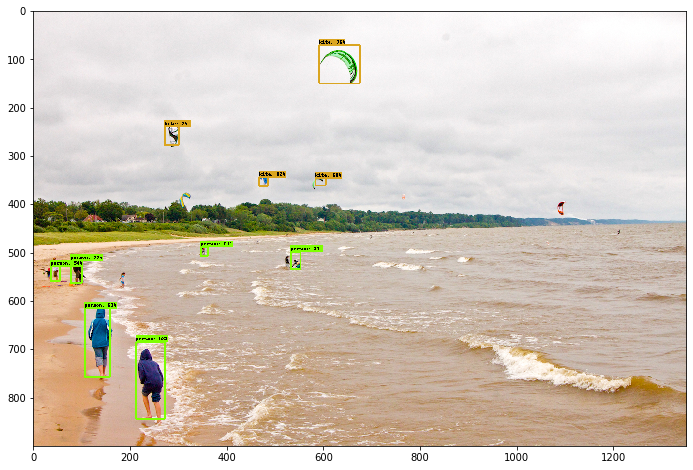

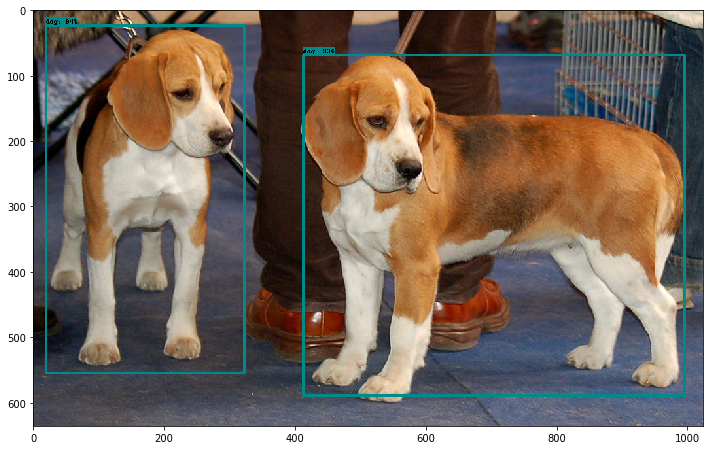

In [19]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=4)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.grid(False)

In [20]:
# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Tests for object_detection.models.model_builder."""

from absl.testing import parameterized

import tensorflow as tf

from google.protobuf import text_format
from object_detection.builders import model_builder
from object_detection.meta_architectures import faster_rcnn_meta_arch
from object_detection.meta_architectures import rfcn_meta_arch
from object_detection.meta_architectures import ssd_meta_arch
from object_detection.models import ssd_resnet_v1_fpn_feature_extractor as ssd_resnet_v1_fpn
from object_detection.protos import hyperparams_pb2
from object_detection.protos import losses_pb2
from object_detection.protos import model_pb2


class ModelBuilderTest(tf.test.TestCase, parameterized.TestCase):

  def create_model(self, model_config, is_training=True):
    """Builds a DetectionModel based on the model config.

    Args:
      model_config: A model.proto object containing the config for the desired
        DetectionModel.
      is_training: True if this model is being built for training purposes.

    Returns:
      DetectionModel based on the config.
    """
    return model_builder.build(model_config, is_training=is_training)

  def create_default_ssd_model_proto(self):
    """Creates a DetectionModel proto with ssd model fields populated."""
    model_text_proto = """
      ssd {
        feature_extractor {
          type: 'ssd_inception_v2'
          conv_hyperparams {
            regularizer {
                l2_regularizer {
                }
              }
              initializer {
                truncated_normal_initializer {
                }
              }
          }
          override_base_feature_extractor_hyperparams: true
        }
        box_coder {
          faster_rcnn_box_coder {
          }
        }
        matcher {
          argmax_matcher {
          }
        }
        similarity_calculator {
          iou_similarity {
          }
        }
        anchor_generator {
          ssd_anchor_generator {
            aspect_ratios: 1.0
          }
        }
        image_resizer {
          fixed_shape_resizer {
            height: 320
            width: 320
          }
        }
        box_predictor {
          convolutional_box_predictor {
            conv_hyperparams {
              regularizer {
                l2_regularizer {
                }
              }
              initializer {
                truncated_normal_initializer {
                }
              }
            }
          }
        }
        loss {
          classification_loss {
            weighted_softmax {
            }
          }
          localization_loss {
            weighted_smooth_l1 {
            }
          }
        }
      }"""
    model_proto = model_pb2.DetectionModel()
    text_format.Merge(model_text_proto, model_proto)
    return model_proto

  def create_default_faster_rcnn_model_proto(self):
    """Creates a DetectionModel proto with FasterRCNN model fields populated."""
    model_text_proto = """
      faster_rcnn {
        inplace_batchnorm_update: false
        num_classes: 3
        image_resizer {
          keep_aspect_ratio_resizer {
            min_dimension: 600
            max_dimension: 1024
          }
        }
        feature_extractor {
          type: 'faster_rcnn_resnet101'
        }
        first_stage_anchor_generator {
          grid_anchor_generator {
            scales: [0.25, 0.5, 1.0, 2.0]
            aspect_ratios: [0.5, 1.0, 2.0]
            height_stride: 16
            width_stride: 16
          }
        }
        first_stage_box_predictor_conv_hyperparams {
          regularizer {
            l2_regularizer {
            }
          }
          initializer {
            truncated_normal_initializer {
            }
          }
        }
        initial_crop_size: 14
        maxpool_kernel_size: 2
        maxpool_stride: 2
        second_stage_box_predictor {
          mask_rcnn_box_predictor {
            conv_hyperparams {
              regularizer {
                l2_regularizer {
                }
              }
              initializer {
                truncated_normal_initializer {
                }
              }
            }
            fc_hyperparams {
              op: FC
              regularizer {
                l2_regularizer {
                }
              }
              initializer {
                truncated_normal_initializer {
                }
              }
            }
          }
        }
        second_stage_post_processing {
          batch_non_max_suppression {
            score_threshold: 0.01
            iou_threshold: 0.6
            max_detections_per_class: 100
            max_total_detections: 300
          }
          score_converter: SOFTMAX
        }
      }"""
    model_proto = model_pb2.DetectionModel()
    text_format.Merge(model_text_proto, model_proto)
    return model_proto

  def test_create_ssd_models_from_config(self):
    model_proto = self.create_default_ssd_model_proto()
    ssd_feature_extractor_map = {}
    ssd_feature_extractor_map.update(
        model_builder.SSD_FEATURE_EXTRACTOR_CLASS_MAP)
    ssd_feature_extractor_map.update(
        model_builder.SSD_KERAS_FEATURE_EXTRACTOR_CLASS_MAP)

    for extractor_type, extractor_class in ssd_feature_extractor_map.items():
      model_proto.ssd.feature_extractor.type = extractor_type
      model = model_builder.build(model_proto, is_training=True)
      self.assertIsInstance(model, ssd_meta_arch.SSDMetaArch)
      self.assertIsInstance(model._feature_extractor, extractor_class)

  def test_create_ssd_fpn_model_from_config(self):
    model_proto = self.create_default_ssd_model_proto()
    model_proto.ssd.feature_extractor.type = 'ssd_resnet101_v1_fpn'
    model_proto.ssd.feature_extractor.fpn.min_level = 3
    model_proto.ssd.feature_extractor.fpn.max_level = 7
    model = model_builder.build(model_proto, is_training=True)
    self.assertIsInstance(model._feature_extractor,
                          ssd_resnet_v1_fpn.SSDResnet101V1FpnFeatureExtractor)
    self.assertEqual(model._feature_extractor._fpn_min_level, 3)
    self.assertEqual(model._feature_extractor._fpn_max_level, 7)


  @parameterized.named_parameters(
      {
          'testcase_name': 'mask_rcnn_with_matmul',
          'use_matmul_crop_and_resize': False,
          'enable_mask_prediction': True
      },
      {
          'testcase_name': 'mask_rcnn_without_matmul',
          'use_matmul_crop_and_resize': True,
          'enable_mask_prediction': True
      },
      {
          'testcase_name': 'faster_rcnn_with_matmul',
          'use_matmul_crop_and_resize': False,
          'enable_mask_prediction': False
      },
      {
          'testcase_name': 'faster_rcnn_without_matmul',
          'use_matmul_crop_and_resize': True,
          'enable_mask_prediction': False
      },
  )
  def test_create_faster_rcnn_models_from_config(
      self, use_matmul_crop_and_resize, enable_mask_prediction):
    model_proto = self.create_default_faster_rcnn_model_proto()
    faster_rcnn_config = model_proto.faster_rcnn
    faster_rcnn_config.use_matmul_crop_and_resize = use_matmul_crop_and_resize
    if enable_mask_prediction:
      faster_rcnn_config.second_stage_mask_prediction_loss_weight = 3.0
      mask_predictor_config = (
          faster_rcnn_config.second_stage_box_predictor.mask_rcnn_box_predictor)
      mask_predictor_config.predict_instance_masks = True

    for extractor_type, extractor_class in (
        model_builder.FASTER_RCNN_FEATURE_EXTRACTOR_CLASS_MAP.items()):
      faster_rcnn_config.feature_extractor.type = extractor_type
      model = model_builder.build(model_proto, is_training=True)
      self.assertIsInstance(model, faster_rcnn_meta_arch.FasterRCNNMetaArch)
      self.assertIsInstance(model._feature_extractor, extractor_class)
      if enable_mask_prediction:
        self.assertAlmostEqual(model._second_stage_mask_loss_weight, 3.0)

  def test_create_faster_rcnn_model_from_config_with_example_miner(self):
    model_proto = self.create_default_faster_rcnn_model_proto()
    model_proto.faster_rcnn.hard_example_miner.num_hard_examples = 64
    model = model_builder.build(model_proto, is_training=True)
    self.assertIsNotNone(model._hard_example_miner)

  def test_create_rfcn_model_from_config(self):
    model_proto = self.create_default_faster_rcnn_model_proto()
    rfcn_predictor_config = (
        model_proto.faster_rcnn.second_stage_box_predictor.rfcn_box_predictor)
    rfcn_predictor_config.conv_hyperparams.op = hyperparams_pb2.Hyperparams.CONV
    for extractor_type, extractor_class in (
        model_builder.FASTER_RCNN_FEATURE_EXTRACTOR_CLASS_MAP.items()):
      model_proto.faster_rcnn.feature_extractor.type = extractor_type
      model = model_builder.build(model_proto, is_training=True)
      self.assertIsInstance(model, rfcn_meta_arch.RFCNMetaArch)
      self.assertIsInstance(model._feature_extractor, extractor_class)

  def test_invalid_model_config_proto(self):
    model_proto = ''
    with self.assertRaisesRegexp(
        ValueError, 'model_config not of type model_pb2.DetectionModel.'):
      model_builder.build(model_proto, is_training=True)

  def test_unknown_meta_architecture(self):
    model_proto = model_pb2.DetectionModel()
    with self.assertRaisesRegexp(ValueError, 'Unknown meta architecture'):
      model_builder.build(model_proto, is_training=True)

  def test_unknown_ssd_feature_extractor(self):
    model_proto = self.create_default_ssd_model_proto()
    model_proto.ssd.feature_extractor.type = 'unknown_feature_extractor'
    with self.assertRaisesRegexp(ValueError, 'Unknown ssd feature_extractor'):
      model_builder.build(model_proto, is_training=True)

  def test_unknown_faster_rcnn_feature_extractor(self):
    model_proto = self.create_default_faster_rcnn_model_proto()
    model_proto.faster_rcnn.feature_extractor.type = 'unknown_feature_extractor'
    with self.assertRaisesRegexp(ValueError,
                                 'Unknown Faster R-CNN feature_extractor'):
      model_builder.build(model_proto, is_training=True)

  def test_invalid_first_stage_nms_iou_threshold(self):
    model_proto = self.create_default_faster_rcnn_model_proto()
    model_proto.faster_rcnn.first_stage_nms_iou_threshold = 1.1
    with self.assertRaisesRegexp(ValueError,
                                 r'iou_threshold not in \[0, 1\.0\]'):
      model_builder.build(model_proto, is_training=True)
    model_proto.faster_rcnn.first_stage_nms_iou_threshold = -0.1
    with self.assertRaisesRegexp(ValueError,
                                 r'iou_threshold not in \[0, 1\.0\]'):
      model_builder.build(model_proto, is_training=True)

  def test_invalid_second_stage_batch_size(self):
    model_proto = self.create_default_faster_rcnn_model_proto()
    model_proto.faster_rcnn.first_stage_max_proposals = 1
    model_proto.faster_rcnn.second_stage_batch_size = 2
    with self.assertRaisesRegexp(
        ValueError, 'second_stage_batch_size should be no greater '
        'than first_stage_max_proposals.'):
      model_builder.build(model_proto, is_training=True)

  def test_invalid_faster_rcnn_batchnorm_update(self):
    model_proto = self.create_default_faster_rcnn_model_proto()
    model_proto.faster_rcnn.inplace_batchnorm_update = True
    with self.assertRaisesRegexp(ValueError,
                                 'inplace batchnorm updates not supported'):
      model_builder.build(model_proto, is_training=True)

  def test_create_experimental_model(self):

    model_text_proto = """
      experimental_model {
        name: 'model42'
      }"""

    build_func = lambda *args: 42
    model_builder.EXPERIMENTAL_META_ARCH_BUILDER_MAP['model42'] = build_func
    model_proto = model_pb2.DetectionModel()
    text_format.Merge(model_text_proto, model_proto)

    self.assertEqual(model_builder.build(model_proto, is_training=True), 42)


if __name__ == '__main__':
  tf.test.main()


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



ModuleNotFoundError: ignored